Modéle LSTM 


Imports


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import json
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # utilisation cpu ou gpu selon la machine
print(f"Utilisation du périphérique : {device}")

PATH = r"yelp_academic_reviews4students.jsonl"
VOCAB_SIZE = 20000 
MAX_LEN = 150
EMBED_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 40


Utilisation du périphérique : cuda


Préparation données 

In [4]:

data = [] # liste pour stocker JSON

with open(PATH, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))# passer en dictionnaire python 

df_full = pd.DataFrame(data)


def labeler(s):
    if s > 3: return 1  
    if s < 3: return 0  
    return 2            

df_full['label'] = df_full['stars'].apply(labeler)# Création colonne 'label' en appliquant la fonction labeler à 'stars'

# Calcul nombre d'occurrences pour la classe la moins représentée (souvent le Neutre)
# définit le seuil pour un échantillonnage égalitaire (Under-sampling)
N_TOTAL = 20000
N_PER_CLASS = N_TOTAL // 3 # Soit 6666 avis par classe

df = pd.concat([
    df_full[df_full['label'] == 0].sample(N_PER_CLASS, random_state=42),
    df_full[df_full['label'] == 1].sample(N_PER_CLASS, random_state=42),
    df_full[df_full['label'] == 2].sample(N_PER_CLASS, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset LSTM réduit à {len(df)} lignes ({N_PER_CLASS} par classe).")# melange et refait les index pour eviter que tout se suive 

Dataset LSTM réduit à 19998 lignes (6666 par classe).


Tokenisation manuelle

In [5]:

def clean(t):
    return re.sub(r"[^a-z\s']", " ", str(t).lower()).split() # re.sub remplace les caractères non-alphabétiques par espace/ .split() découpe chaîne en liste de mots

X_raw = [clean(t) for t in df['text']] # nettoyage du dataframe 
y = df['label'].values# Extraction labels en vecteur NumPy pour compatibilité Scikit-learn

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, stratify=y) # division dataset + stratify pour que proportion égale entre train et test 

all_words = [word for text in X_train_raw for word in text] # Aplatissement listes X_train_raw -> liste géante de tous les mots du train

# Création du dictionnaire correspondance mot -> indice (id)
# most_common(VOCAB_SIZE-2) sélectionne mots fréquents pour limiter taille dictionnaire
# i+2 décale les indices pour réserver les places 0 et 1 aux jetons spéciaux
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_words).most_common(VOCAB_SIZE-2))}

# Définition manuelle des jetons spéciaux : 0 pour le remplissage (Padding), 1 pour les mots inconnus (Out-Of-Vocabulary)
vocab["<PAD>"] = 0
vocab["<OOV>"] = 1

def encode(text): # transformer  liste de mots en une liste d'entiers de longueur fixe (MAX_LEN)
    # Traduction des mots : récupère l'ID du mot ou 1 (<OOV>) s'il n'est pas dans le vocabulaire ; tronque à MAX_LEN
    encoded = [vocab.get(w, 1) for w in text][:MAX_LEN]
    # Padding : ajoute des 0 à la fin si le texte est plus court que MAX_LEN pour uniformiser la taille des batchs
    return encoded + [0] * (MAX_LEN - len(encoded))

# Conversion des listes de listes d'entiers en Tenseurs PyTorch (entrée du modèle)
X_train = torch.tensor([encode(t) for t in X_train_raw])
X_test = torch.tensor([encode(t) for t in X_test_raw])

# Conversion labels en Tenseurs PyTorch
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

Architecture LSTM

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        # Table de correspondance : index -> vecteur dense. padding_idx=0 neutralise l'impact du vide
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # LSTM bidirectionnel : lit dans les deux sens pour capturer contexte global
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5) # suppression de neurones
        self.fc = nn.Linear(hidden_dim * 2, 3) # Sortie  vers 3 scores de probabilité
        
    def forward(self, x):
        embedded = self.embedding(x) # [Batch, Seq_len] -> [Batch, Seq_len, Embed_dim]
        _, (hidden, _) = self.lstm(embedded) # Extraction des états de mémoire (h_n)
        # Concatène h_n du passage forward (-2) et backward (-1)
        out = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(out)) # Projection finale après régularisation

# Déplacement du modèle sur GPU/CPU
model = LSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(device)
# Optimiseur Adam : ajuste les poids via gradients. LR standard 1e-3.
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Fonction de coût : calcule l'erreur entre prédiction (logits) et réalité (labels).
criterion = nn.CrossEntropyLoss()

Entrainement

In [7]:
# Préparation des batchs de 64 exemples avec mélange aléatoire
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True)

model.train() # Mode entraînement : active le Dropout
for epoch in range(EPOCHS):
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device) # Transfert GPU
        optimizer.zero_grad() # Remise à zéro des gradients pour éviter l'accumulation
        outputs = model(texts) # Passage vers l'avant (Forward)
        loss = criterion(outputs, labels) # Calcul de l'erreur
        loss.backward() # Rétropropagation de l'erreur
        optimizer.step() # Mise à jour des poids
        total_loss += loss.item()
    print(f"Époque {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")

Époque 1 - Loss: 0.9850
Époque 2 - Loss: 0.8180
Époque 3 - Loss: 0.6928
Époque 4 - Loss: 0.6207
Époque 5 - Loss: 0.5032
Époque 6 - Loss: 0.4066
Époque 7 - Loss: 0.3375
Époque 8 - Loss: 0.2844
Époque 9 - Loss: 0.2261
Époque 10 - Loss: 0.1884
Époque 11 - Loss: 0.1580
Époque 12 - Loss: 0.1239
Époque 13 - Loss: 0.1304
Époque 14 - Loss: 0.1114
Époque 15 - Loss: 0.0750
Époque 16 - Loss: 0.0689
Époque 17 - Loss: 0.0727
Époque 18 - Loss: 0.0511
Époque 19 - Loss: 0.0339
Époque 20 - Loss: 0.0252
Époque 21 - Loss: 0.0484
Époque 22 - Loss: 0.0495
Époque 23 - Loss: 0.0352
Époque 24 - Loss: 0.0518
Époque 25 - Loss: 0.0290
Époque 26 - Loss: 0.0215
Époque 27 - Loss: 0.0152
Époque 28 - Loss: 0.0123
Époque 29 - Loss: 0.0258
Époque 30 - Loss: 0.0296
Époque 31 - Loss: 0.0147
Époque 32 - Loss: 0.0158
Époque 33 - Loss: 0.0117
Époque 34 - Loss: 0.0056
Époque 35 - Loss: 0.0191
Époque 36 - Loss: 0.0307
Époque 37 - Loss: 0.0154
Époque 38 - Loss: 0.0187
Époque 39 - Loss: 0.0225
Époque 40 - Loss: 0.0185


Evaluation


              precision    recall  f1-score   support

     Négatif       0.72      0.74      0.73      1333
     Positif       0.80      0.69      0.74      1334
      Neutre       0.57      0.63      0.60      1333

    accuracy                           0.69      4000
   macro avg       0.70      0.69      0.69      4000
weighted avg       0.70      0.69      0.69      4000



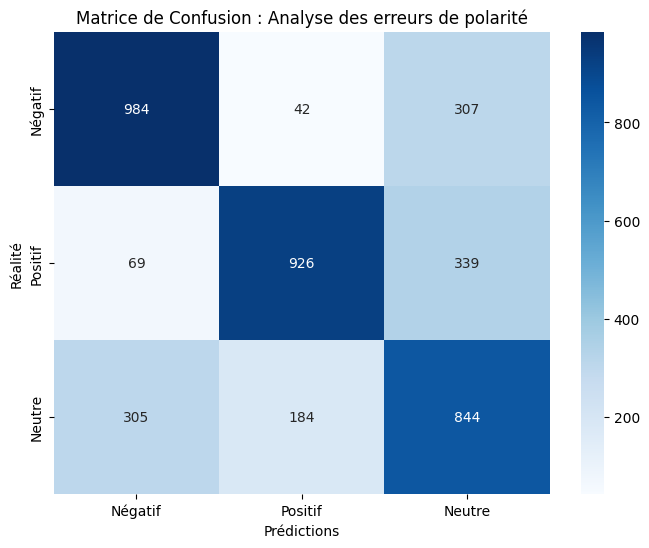

In [ ]:
model.eval() # Mode évaluation : désactive le Dropout
all_preds = []
test_loader = DataLoader(X_test, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad(): # Désactive le calcul de gradient (économie de mémoire)
    for texts in test_loader:
        texts = texts.to(device)
        outputs = model(texts)
        # Récupère l'indice de la probabilité maximale (0, 1 ou 2)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
print(classification_report(y_test, all_preds, target_names=['Négatif', 'Positif', 'Neutre']))
cm = confusion_matrix(y_test.cpu().numpy(), all_preds)


# Configuration de la visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif', 'Neutre'], 
            yticklabels=['Négatif', 'Positif', 'Neutre'])

plt.xlabel('Prédictions') 
plt.ylabel('Réalité')       
plt.title('Matrice de Confusion : Analyse des erreurs de polarité')
plt.show() 